In [119]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

rho   =  917.      # kg/m3
g     =    9.80665 # m/s2
fd    =    1.9E-24 # # pa-3 s-1 # this value and dimension is only correct for n=3
fs    =    5.7E-20 # # pa-3 m2 s-1 # this value and dimension is only correct for n=3


# this ELA list is not quite systematic, so make it systematic!
# elalist = np.array([1800.])  # m , 1750., 1700., 1500., 2200., 1900., 1800.,
# elayear = np.array([ 500], dtype=int)  # years    ,    100,   100,   150,    10,   100,   100

cd    = 2/5*(rho**3)*(g**3)*fd  # <<< this must be adjused according to your discretisation -- Done
cs    = (rho**3)*(g**3)*fs  # <<< this must be adjused according to your discretisation -- Done


def get_bedrock(xaxis,slope=0.08):
    '''
    Function to get bedrock. 
    IN: 
    xaxis = array
    slope = slope of underground, scalar
    OUT:
    bedrock profile
    '''
    # here you put in your own equation that defines the bedrock
    bedrock = 2000. - xaxis*slope
    return bedrock

def get_responsetime(dataarray, initial_year):  
    print('Define your function to estimate the response time for the change after year {0:4d}'.format(initial_year))

    
    response_time = 0   
    
    return response_time, initial_year + response_time

def icemodel(elalist,elayear,totL=20000,dx=100,ntpy=200,ZeroFluxBoundary=True,FluxAtPoints=True,ndyfigure=5,dbdh=0.007, maxb=2):
    StopWhenOutOfDomain = True  
    # Start calculations
    # constants that rely on input
    nx    = int(totL/dx)
    dx    = totL/nx       # redefine, as it     
    xaxis = np.linspace(0,totL,nx,False) + dx*0.5
    xhaxs = np.linspace(dx,totL,nx-1,False) / 1000.

    bedrock = get_bedrock(xaxis)

    dt    = 365.*86400./ntpy # in seconds!
    

    hice   = np.zeros(nx)    # ice thickness
    dhdx   = np.zeros(nx)    # the local gradient of h
    fluxd  = np.zeros(nx+2)  # this will be the flux per second!!!!
    fluxs  = np.zeros(nx+2)  # this will be the flux per second!!!!
    dhdtif = np.zeros(nx)    # change in ice thickness due to the ice flux, per second
    smb    = np.zeros(nx)

    # preparations for the ela-selection
    # elaswch is a list of time steps on which a new ela value should be used.
    nyear    = int(np.sum(elayear))
    nela     = np.size(elalist)

    assert nela == np.size(elayear), "the arrays of elalist and elayear does not have the same length!" 
    elaswch = np.zeros(nela)
    for i in range(0,nela-1):
        elaswch[i+1] = elaswch[i] + (elayear[i]*ntpy)
    ela     = elalist[0]
    

    # preparations for the animation
    nframes  = nyear//ndyfigure + 1
    hsurfmem = np.zeros([nx,nframes])
    smbmem   = np.zeros([nx,nframes])
    ifdmem   = np.zeros([nx,nframes])
    fldmem   = np.zeros([nx-1,nframes])
    flsmem   = np.zeros([nx-1,nframes])
    iframes  = 0

    # preparations for response time calculations
    lengthmem = np.zeros(nyear+1)
    volumemem = np.zeros(nyear+1)
    elamemory = np.zeros(nyear+1)
    yearlist  = np.arange(nyear+1)
    
    # (re)set initial values so that the accumulation area has glacier right away.
    hice = np.where(bedrock>ela, np.where(hice<0.11, 0.11, hice), hice)
    
    lengthmem[0] = np.sum(np.where(hice>0.1, dx, 0.))
    volumemem[0] = np.sum(hice)*dx
    elamemory[0] = ela


    #0-----------------------------------------------------------------------------
    print("Run model for {0:3d} years".format(nyear))

    for it in range(1, ntpy*nyear+1):
        h = hice + bedrock
        if FluxAtPoints:
            dhdx[1:-1] = (h[2:]-h[:-2])/(2*dx)

            # the following equations needs to be adjusted according to your discretisation
            # note that flux[1] is at the point 0
            fluxd[1:-1] = cd * (dhdx)**3 * (hice)**5  
            fluxs[1:-1] = cs * (dhdx)**3 * (hice)**3

            # derive flux convergence
            dhdtif[:]  = (fluxd[2:]-fluxd[:-2]+fluxs[2:]-fluxs[:-2])/(2*dx)
        else:
            # the following equations needs to be adjusted according to your discretisation
            dhdx[:-1]  = ((h[1:]-h[:-1])/dx) # so 0 is at 1/2 actually
            # note that flux[1] is at the point 1/2
            fluxd[1:-2] = cd * dhdx[:-1]**3 * ( ((hice[1:]**5)+(hice[:-1])**5) * 0.5 )
            fluxs[1:-2] = cs * dhdx[:-1]**3 * ( ((hice[1:]**3)+(hice[:-1])**3) * 0.5 )

            # derive flux convergence
            dhdtif[:]  = (fluxd[1:-1]-fluxd[:-2] + fluxs[1:-1]-fluxs[:-2])/dx

        # calculate smb (per year)
        # first update ela (once a year)
        if it%ntpy == 1:
            # lists the elements of elaswch that are equal or smaller than it
            [ielanow] = np.nonzero(elaswch<=it) 
            # the last one is the current ela
            ela       = elalist[ielanow[-1]]   

        smb[:] = (h-ela)*dbdh
        smb[:] = np.where(smb>maxb, maxb, smb) 

        hice   += smb/ntpy + dt*dhdtif
        hice[:] = np.where(hice<0., 0., hice) # remove negative ice thicknesses

        if ZeroFluxBoundary == False:
            hice[0] = hice[-1] = 0.

        if it%ntpy == 0:
            if np.any(np.isnan(hice)):
                print('Values got NaN!')
                break
            iy = it//ntpy
            lengthmem[iy] = np.sum(np.where(hice>0.1, dx, 0.))
            volumemem[iy] = np.sum(hice)*dx
            elamemory[iy] = ela

        if it%(ndyfigure*ntpy) == 0:
            iframes            += 1
            hsurfmem[:,iframes] = hice + bedrock
            smbmem[:,iframes]   = smb
            ifdmem[:,iframes]   = dhdtif[:]*365.*86400.
            fldmem[:,iframes]   = -fluxd[1:-2]*365.*86400.
            flsmem[:,iframes]   = -fluxs[1:-2]*365.*86400.
            if StopWhenOutOfDomain:
                if hice[-1]>1.:
                    print("Ice at end of domain!")
                    break

    #------------------------------------------------------------------------------        
    # at this point, the simulation is completed.        
    # the following is needed to make the animation        
    fig  = plt.figure()
    ax1  = fig.add_subplot(311, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(np.min(bedrock),np.max(hsurfmem)+10.))
    ax1.set_ylabel('meter')
    ax1.set_xlabel('km')
    mina2 = min(np.min(smbmem),np.min(ifdmem))
    maxa2 = max(np.max(smbmem),np.max(ifdmem))
    ax2   = fig.add_subplot(312, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(mina2,maxa2))
    ax2.set_ylabel('I dont know')
    ax2.set_xlabel('km')
    mina3 = min(np.min(fldmem),np.min(flsmem))
    maxa3 = max(np.max(fldmem),np.max(flsmem))
    ax3   = fig.add_subplot(313, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(mina3,maxa3))
    ax3.set_xlabel('km')
    ax3.set_ylabel('fluxd/fluxm')


    # define the line types
    bedrline, = ax1.plot([],[],'-', c='saddlebrown') 
    hsrfline, = ax1.plot([],[],'-', c='navy') #bedrline, +total surface 
    
    time_template = 'time = %d y'
    time_text = ax1.text(0.5, 0.92, '', transform=ax1.transAxes )
    smbline,  = ax2.plot([],[],'-', c='navy') #surface mass balance
    ifdline,  = ax2.plot([],[],'-', c='red') #ifd
    fxdline,  = ax3.plot([],[],'-', c='navy') #flux
    fxsline,  = ax3.plot([],[],'-', c='red') #flux

    # initialize the animation
    def init_anim():
        '''function for initial animamtion'''
        bedrline.set_data([], [])
        hsrfline.set_data([], [])
        time_text.set_text('')
        smbline.set_data([], [])
        ifdline.set_data([], [])
        fxdline.set_data([], [])
        fxsline.set_data([], [])

        return bedrline, hsrfline, time_text, smbline, ifdline, fxdline, fxsline

    # update the animation with data for saved frame #tf
    def animate(tf):
        bedrline.set_data(xaxis/1000., bedrock)
        hsrfline.set_data(xaxis/1000., hsurfmem[:,tf]) 
        time_text.set_text(time_template % int(tf*ndyfigure))
        smbline.set_data(xaxis/1000.,  smbmem[:,tf])
        ifdline.set_data(xaxis/1000.,  ifdmem[:,tf])
        fxdline.set_data(xhaxs      ,  fldmem[:,tf])
        fxsline.set_data(xhaxs      ,  flsmem[:,tf])
        return bedrline, hsrfline, time_text, smbline, ifdline, fxdline, fxsline

    # call and run animation
    ani = animation.FuncAnimation(fig, animate, np.arange(iframes),
             interval=25, blit=True, init_func=init_anim) 
    
    writergif = animation.PillowWriter(fps=30)
    
    f = r"c://Users/lasse/Documents/IC/animation.gif" 
    ani.save(f, writer=writergif)
#     plt.show()
    # SAVING PYTHON MOVIES IS PLATFORM DEPENDEND.     

    
    #------------------------------------------------------------------------------ 
    # postprocessing

    ResponseTimes = np.zeros(nela)
    ResponseYears = np.zeros(nela)

    # The first ela value is excluded from the analysis as that has the spin-up
    # Here, the length is used for the responsetime. One could also take the mass. 
    #  If desired, do not use lengthmem but volumemem.
    ys = elayear[0]
    for i in range(1,nela):
        if i == nela-1:
            ye = nyear
        else:
            ye = ys + elayear[i]
        ResponseTimes[i], ResponseYears[i] = get_responsetime(lengthmem[ys:ye], ys)

        ys = ye



    fig2,ax2a = plt.subplots()
    ax2a.plot(yearlist,lengthmem/1000. ,'k') #Black line 
    ax2a.set_xlabel('Model year (yr)')
    ax2a.set_ylabel('Glacier length (km)')
    ax2a.set_xlim([0, nyear])
    lmima = [ np.min(lengthmem/1000.), np.max(lengthmem/1000.) ]
    for i in range(1,nela):
        ax2a.plot([ResponseYears[i],ResponseYears[i]], lmima, 'b') #Blue line


    ax2b  = ax2a.twinx()
    color = 'tab:red'
    ax2b.plot(yearlist, elamemory, color=color) #Red line
    ax2b.set_ylabel('Ela', color=color)
    ax2b.tick_params(axis='y', labelcolor=color)   


    fig3,ax3 = plt.subplots()
    ax3.scatter(elalist[1:], ResponseTimes[1:])
    ax3.set_xlabel('ELA list')
    ax3.set_ylabel('Response Time')
    print(ResponseTimes)
    print(ResponseYears)
    print(fldmem)
    print(ela)

                        

                        


Run model for 600 years


<IPython.core.display.Javascript object>


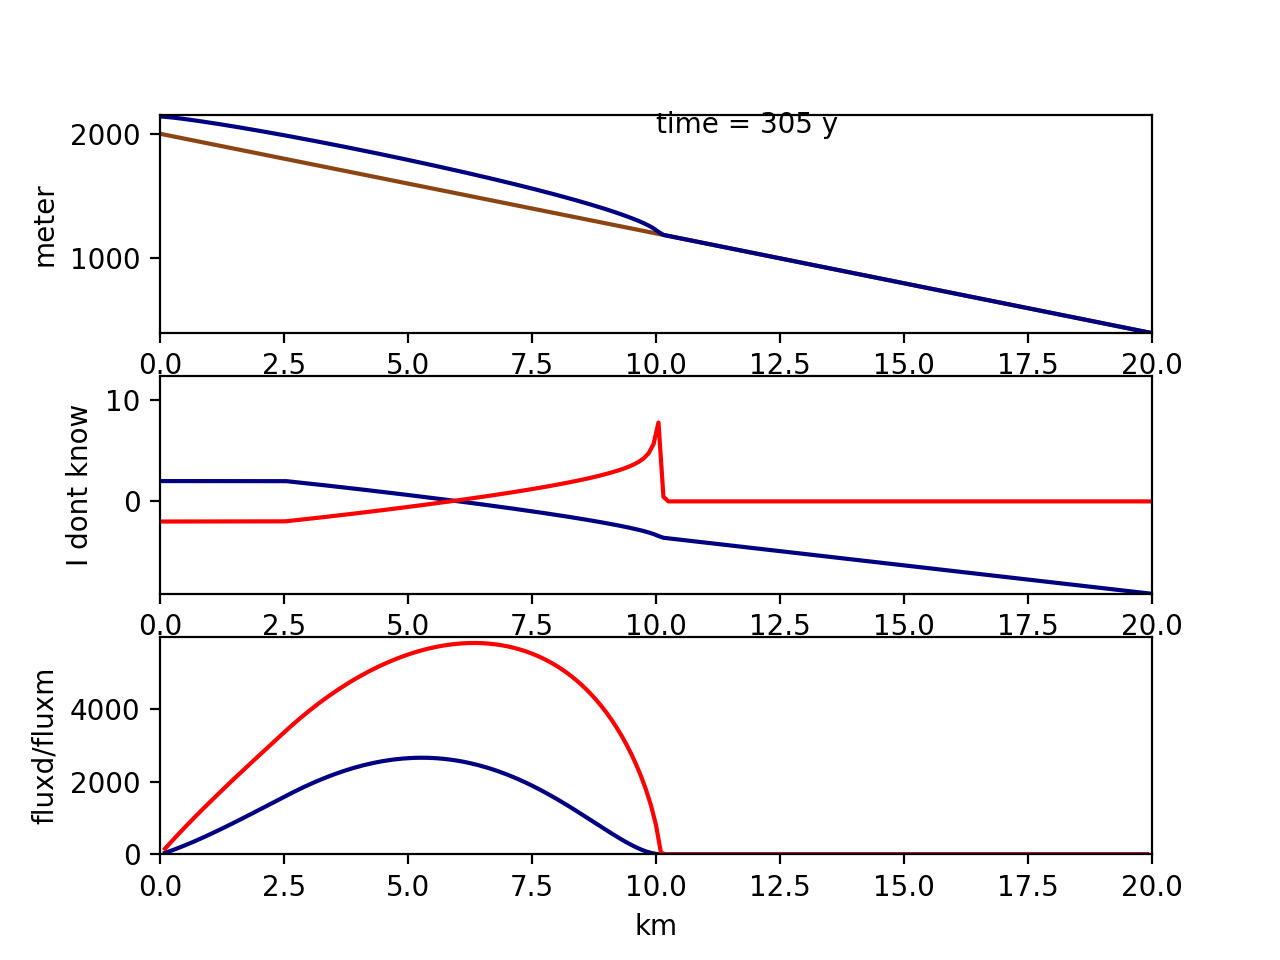

<IPython.core.display.Javascript object>


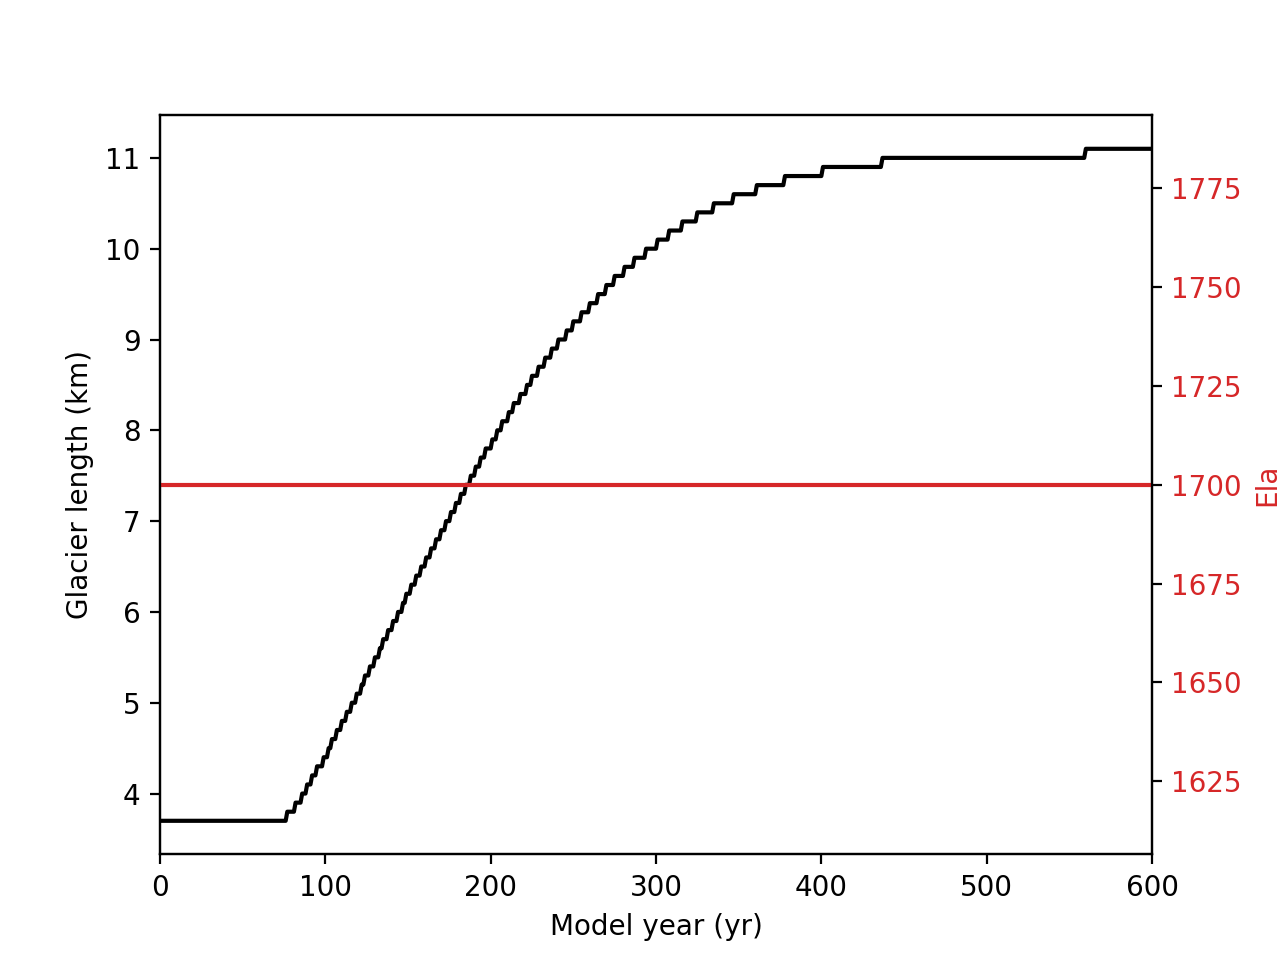

<IPython.core.display.Javascript object>


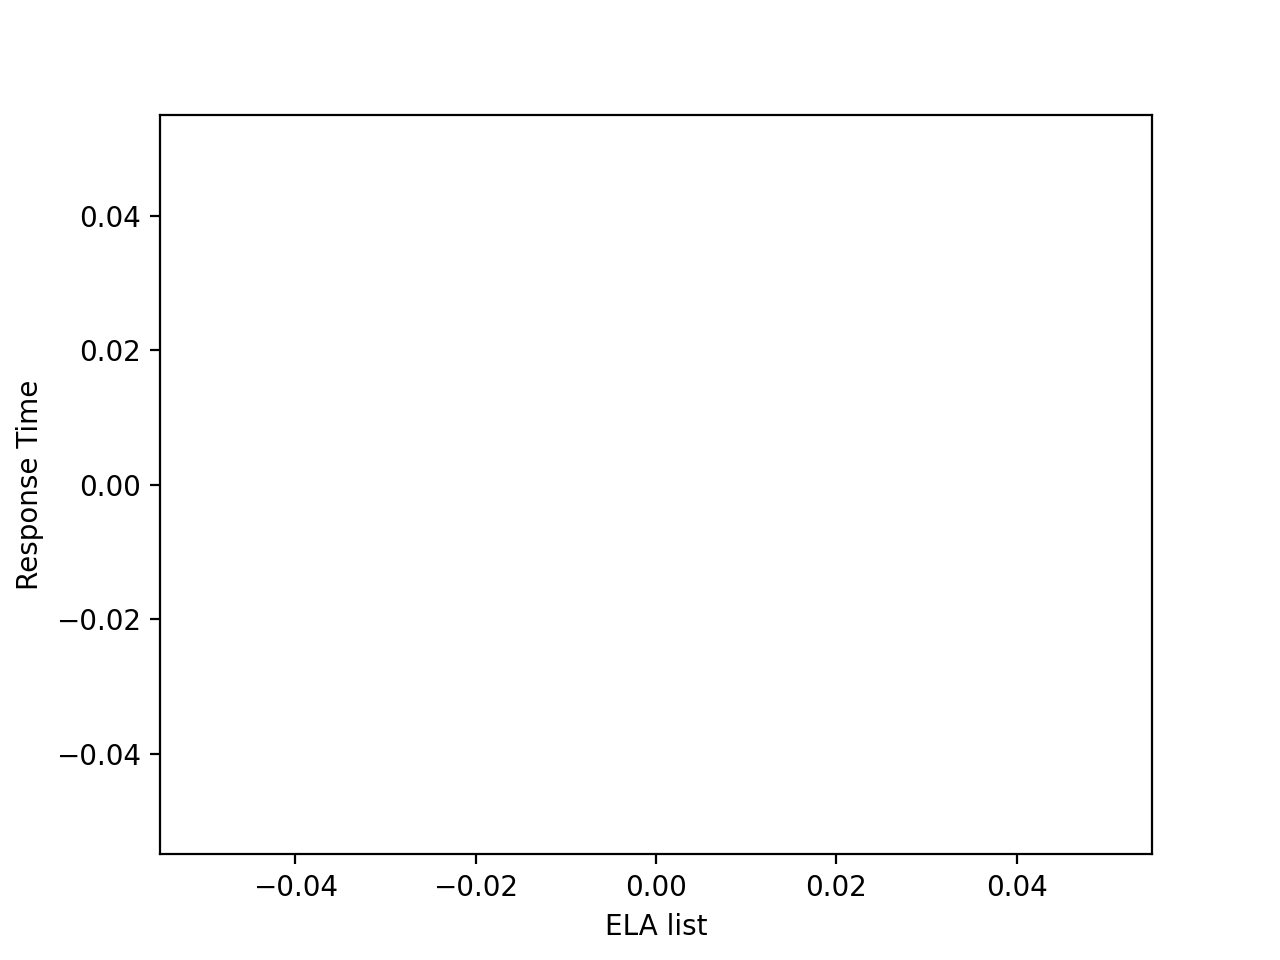

[0.]
[0.]
[[0.00000000e+00 9.32882841e-04 2.74323565e-02 ... 4.38755385e+01
  4.38761496e+01 4.38767032e+01]
 [0.00000000e+00 9.44548096e-04 2.96463981e-02 ... 9.17144803e+01
  9.17157469e+01 9.17168941e+01]
 [0.00000000e+00 9.41384202e-04 3.08096263e-02 ... 1.42695173e+02
  1.42697136e+02 1.42698915e+02]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
1700


In [121]:
if __name__ == '__main__':
    %matplotlib notebook
    icemodel(elalist=([1700]),elayear=([600]),dx=100, FluxAtPoints=False)